# Практическое ДЗ-2. Использование ALS для построения рекомендательной модели

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений разреженных матриц.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) или [disk.yandex.ru](https://disk.yandex.ru/d/Wu7xqOagVGGwMg) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [5]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('drive/MyDrive/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A \in \mathbb R^{m \times n}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{i,j}=1$) и отрицательные (`Rating < 4` &mdash; $A_{i,j} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате хранения разреженных матриц [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)), который поддерживает матричное умножение на numpy массивы: ```A @ X ```.

In [6]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [7]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

Далее в задаче мы будем строить рекомендации пользователям на основе малорангового приближения матрицы $A$ (матрицы $A_{train}$ в рамках обозначений выше). 
Обратим внимание, что из-за ограничений по памяти мы не можем сформировать матрицу $A$ в виде numpy массива, а значит теряем доступ к ```np.linalg.svd```. Поэтому мы будем реализовывать метод ALS, в котором требуется только умножение на матрицы $A$ и $A^\top$, что поддерживается разреженными форматами хранения матриц (CSR, COO и тд).

### a. (35 баллов) Вычисление вспомогательных функционалов

  1. **(15 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $f(U, V^\top) = \|A - UV^\top\|_F$ по всем $U \in \mathbb R^{m \times r}$ и $V  \in \mathbb R^{n \times r}$. Первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - UV^\top\|_F$ для заданных $A$, $U$, $V^\top$. Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - UV^\top\|_F^2$ через скалярное произведение $\langle X,Y \rangle_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Имеется в виду, что ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив).
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @; либо умножения сложности $O(mr^2), O(nr^2)$. Также отметим, что норма матрицы $A$ уже дана, заново её вычислять не надо.

**Решение**. $||A - UV^T||_F^2 = <A - UV^T, A - UV^T>_F = Tr((A - UV^T)^T(A - UV^T)) = Tr((A^T - VU^T)(A - UV^T)) = Tr(A^TA - V(U^TA) - (A^TU)V^T + V(U^TU)V^T) = Tr(A^T A) - Tr(VU^TA) - Tr(A^TUV^T) + Tr(VU^TUV^T).$ Т.к. $Tr(VU^T A) = Tr(U^T AV) = Tr((AV)^T U) = Tr(V^T A^T U) = Tr(A^T U V^T),$ получаем $Tr(A^T A) - 2Tr(A^TUV^T) + Tr(VU^TUV^T).$

$\bullet$ $Tr(A^TUV^T) = Tr((V^TA^T)U)$.$V^TA^T$ размера $r \times m$ умножается на $U$ за $mr^2$ операций.

$\bullet$ $Tr(VU^TUV^T) = Tr((V^T V) (U^T U))$: $V^T V$ за $nr^2$ операций, $U^T U$ --- за $mr^2$, итог: умножение матрицы $r \times r$ на матрицу $r \times r$ за $r^3 \leq mr^2.$

Итого вычисляем $Tr(A^T A) - 2Tr((V^TA^T)U) + Tr((V^T V) (U^T U)).$

Заметим, что $||A||_F^2 = Tr(A^T A).$

In [36]:
def als_functional(A, A_norm, U, VT):
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, VT: 2D arrays such that U @ VT approximates A
        Output
            ||A - U VT||_F
    """
    tr_1 = np.trace((VT @ A.T) @ U)
    tr_2 = np.trace((VT @ VT.T) @ (U.T @ U))
    
    return np.sqrt(A_norm**2 - 2 * tr_1 + tr_2)

**Замечание:** Если вы не сможете выполнить следующие два пункта, можете их пропустить. Они не являются обязательными для следующих заданий.

  2. **(10 баллов)** *Расстоянием от подпространства* $L_1 \subset \mathbb{R}^m$ *до подпространства* $L_2 \subset \mathbb{R}^m$ будем называть число $\|(I - P(L_1)) P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Функция несимметричная, так что будьте осторожны с расстановкой аргументов. Опишите алгоритм вычисления расстояния от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^\top U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

**Решение**. Знаем, что ортопроектор на Im(A), где A --- полного ранга, это $P = A(A^*A)^{-1}A^*$. Т.к. столбцы матриц $U_1, U_2$ ортонормированы, они линейно независимы, потому $U_1, U_2$ --- полного ранга. Значит, $P(Im(U_1)) = U_1(U_1^*U_1)^{-1}U_1^* = U_1U_1^*,$ т.к. столбцы $U_1$ ортонормированы, и $P(Im(U_2)) = U_2(U_2^*U_2)^{-1}U_2^* = U_2 U_2^*$ аналогично. Тогда $\rho(U_1, U_2) = ||(I - P(Im(U_1)))P(Im(U_2))||_2 = ||(I - U_1U_1^*)U_2U_2^*||_2 = ||(U_2 - U_1 (U_1^T U_2))U_2^T||_2.$ 

Найдем QR-разложение матрицы в скобках (матричное умножение в скобках стоит $mr^2$): $Q_1R_1$ --- и матрицы $U_2$: $Q_2R_2$. Тогда ищем $||Q_1R_1R_2^TQ_2^T||_2$. На семинаре считали, что QR-разложение матрицы $m \times n$ ищется за $mn^2$ операций. Таким образом, мы сделаем $mr^2$. Знаем, что если $H$ --- ортогональная матрица, то $||HA||_2 = ||A||_2$ (нужно расписать по определению через sup). Поэтому ищем $||R_1 R_2^T Q_2^T||_2$. $R_1 R_2^T$ умножается за $r^2 m$ операций, получается матрица $r \times r$. Она умножается на $Q_2^T$ за $r^2 m$ операций. Итого алгоритм сложности $O(mr^2)$.

  3. **(10 баллов)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [106]:
def dist_between_subspaces(U1, U2):
    """
        Input
            U1, U2: matrices with orthonormal columns
        Output
            Distance from Im(U1) to Im(U2)
    """
    mat_1 = U2 - U1 @ (U1.T @ U2)
    _, R1 = np.linalg.qr(mat_1)
    Q2, R2 = np.linalg.qr(U2)

    return np.linalg.norm(R1 @ R2.T @ Q2.T, ord=2)

### b. (30 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции).

Вам будет необходимо вернуть две матрицы: $U$ и $V^\top$, образующие скелетное разложение результирующего приближения; где $U$ имеет ортонормированные столбцы. Также нужно вернуть 3 списка:


*   Список значений функционала $f(U_k, V^\top_k) = \|A - U_k V^\top_k\|_F$

*   Список изменений значений функционала $\delta_k = f(U_{k-1}, V^\top_{k-1}) - f(U_k, V^\top_k)$

*   Список растояний между пространствами $\|(I - P(U_{k-1}))P(U_{k})\|_2$

В качестве критерия остановки будем использовать величину $\delta_k$. При значении $\delta_k \le tolerance$ алгоритм должен остановиться. При указании `debug=True` печатайте номер текущей итерации и последнюю $\delta_k$, а также любую дополнительную интересную вам информацию. 

Используйте реализованные выше функции. Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.

**Замечание:** Если вы не реализовали dist_between_subspaces, то вместо третьего списка возращайте None.

**Решение**. Мы решаем задачу минимизации $f(X) = f(UV^T)$. 

$\bullet$ *Алгоритм* до сходимости такой (опишем $k$-й шаг):

$\hat{U} = \underset{U \in \mathbb{R}^{m \times r}}{\text{argmin}} f(UV_k^T)$

$\hat{U} = Q_1 R_1$ --- $QR$-разложение.

$\hat{V} = \underset{V \in \mathbb{R}^{n \times r}}{\text{argmin}} f(Q_1 V^T)$

$\hat{V} = Q_2 R_2$ --- $QR$-разложение.

Тогда $U_{k + 1} = Q_1R_2^T$ (ведь при подстановке $\hat{V} = Q_2R_2$ в $f(Q_1V^T)$ получаем $f((Q_1 R_2^T) Q_1^T)$), $V_{k + 1} = Q_2.$

$\bullet$ Также на лекции для нашего функционала мы подсчитали *оптимальные* значения: $U_* = AV$ при ортогональном $V$, $V_* = A^T U$ --- при ортогональном $U$.

In [116]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rank, tolerance=1e-2, debug=False):
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when delta_k is less or equal to it
            debug: print debug information on each iteration
            
        Output
            U, VT: m x rank, rank x n numpy arrays forming skeleton decomposition;
                   columns of matrix U are orthonormal
            fs: list of f(U_k, VT_k)
            deltas: list of f(U_{k-1}, VT_{k-1}) - f(U_k, VT_k)
            dists: list of distances from Im(U_{k-1}) and Im(U_k)
    """
    def find_optimum(A, V_old):
      U_hat = A @ V_old
      U_q, _ = np.linalg.qr(U_hat)

      V_hat = A.T @ U_q
      V_q, V_r = np.linalg.qr(V_hat)

      U_new = U_q @ V_r.T
      V_new = V_q
      
      return U_new, V_new

    func = []
    deltas = []
    dist = []
    
    # начальные U, V. нужно, чтобы V была ортогональная
    old_V = np.random.randn(A.shape[1], rank)
    old_V, _ = np.linalg.qr(old_V)

    old_U = np.random.randn(A.shape[0], rank)
    old_U, _ = np.linalg.qr(old_U)  # для U нет необходимости, но иначе не сможем умножать на V.T и дальше вычислить error_old

    A_norm = scipy.sparse.linalg.norm(A)
    error_old = als_functional(A, A_norm, old_U, old_V.T) + 1
    error = als_functional(A, A_norm, old_U, old_V.T)  # начальное значение

    while error_old - error > tolerance:
  
      U, V = find_optimum(A, old_V)
      error_old = error
      error = als_functional(A, A_norm, U, V.T)

      func.append(error)
      deltas.append(error_old - error)
      dist.append(dist_between_subspaces(old_U, U))

      old_U = U
      old_V = V

    if debug == True:
        print(len(deltas), error)      

    return U, V.T, func, deltas, dist

Запустим метод на матрице `A_train` и посмотрим на убывание функционала от номера итерации.

12 1640.0271503048555


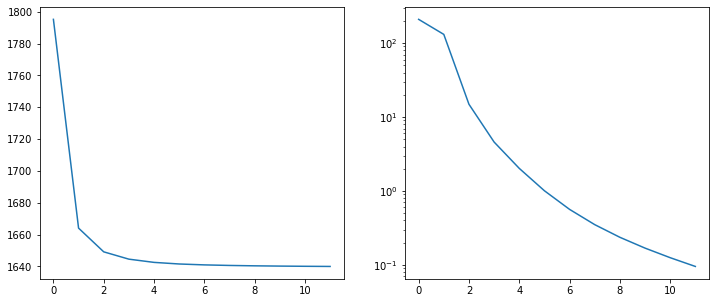

In [112]:
rank = 30
U_als, VT_als, fs, deltas, dists = ALS(A_train, rank, 0.1, debug=True)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].plot(fs)
axs[1].plot(deltas)
axs[1].semilogy();

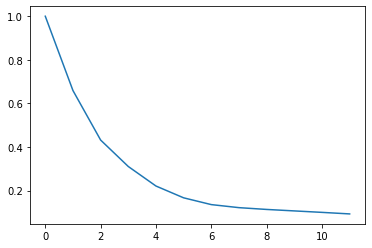

In [115]:
# опционально

plt.plot(dists);

### c. (10 баллов) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также SVD из scipy, поддерживающее разреженные матрицы (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [46]:
A_norm = sparse_norm(A_train)

U, T, V = randomized_svd(A_train, n_components=30, random_state=None)
random = als_functional(A_train, A_norm, U @ np.diag(T), V)

U, T, V = svds(A_train, 30)
svd_sparse = als_functional(A_train, A_norm, U @ np.diag(T), V)

In [47]:
print(random, svd_sparse)

1639.5938754382412 1639.4916365674424


Результаты почти одинаковые.

### d. (25 баллов) Построение рекомендаций
  1. **(10 баллов)** Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `pred_am` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`pred_am` рекомендаций, то есть `pred_am` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

  Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `score_mat` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же. **Подсказка:** используйте функцию `np.argsort`.

In [117]:
def recommend(score_mat, pred_am, V):
    """
        Input
            score_mat: sparse batch_size x n_movies array
            pred_am: requested number of recommendations
            V: 2D numpy array
            
        Output
            recs: batch_size x pred_am array of movies to recommend, with descending predicted rating
    """
    # т.к. образ V --- линейная оболочка столбцов V, мы хотим спроецировать на im(V). Знаем вид ортопроектора. Спроецируем:
    proj_score = V @ (np.linalg.inv(V.T @ V)) @ (V.T @ score_mat.T)

    return np.argsort(-proj_score, axis=0)[:pred_am, :].T

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [118]:
from scipy.sparse import find

def evaluate_model(A_test, pred_am, V, batch_size=500):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_am: requested number of recommendations
            V: 2D numpy array representing the rating model
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-pred_am recommendations (or pred_am if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(A_test[nonempty_users[i:i + batch_size], :], pred_am + 1, V)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

  2. **(15 баллов)** Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `pred_ams`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `pred_ams == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [122]:
def get_hit_rates(A_test, pred_ams, V):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users 
            pred_ams: list of ints: number of top recomendations to evaluate hit rate for
            V: 2D numpy array representing the rating model
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    
    """
    hit = np.array(evaluate_model(A_test, max(pred_ams), V))
    return [(hit < pred_am).mean() for pred_am in pred_ams]

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [123]:
U, S, V = svds(A_train, 30)
get_hit_rates(A_test[:1000, :], [10], V.T)

[0.11225540679711637]

Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

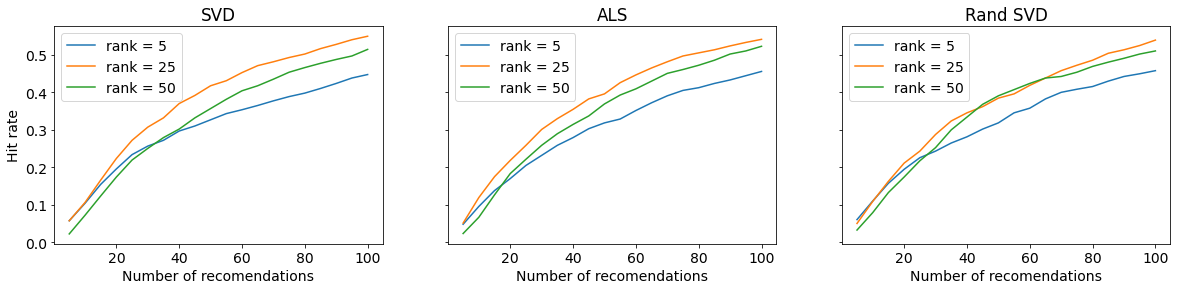

In [124]:
from scipy.sparse.linalg import svds

pred_ams = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, VT_als, _, _, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(A_test[:1000,:], pred_ams, VT.T)
        line, = ax.plot(pred_ams, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

Оптимальный ранг --- 25.